# Import libraries

In [1]:
import pandas as pd
import re

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

In [3]:
from utils.data_funcs import *

In [4]:
%matplotlib notebook

# Load State US daily covid data

In [5]:
us_state_daily_df = get_state_covid_daily_data()
us_state_daily_df

,state,date,cases,deaths
0,Alabama,2020-03-13,6.0,0.0
1,Alabama,2020-03-14,6.0,0.0
2,Alabama,2020-03-15,11.0,0.0
3,Alabama,2020-03-16,6.0,0.0
4,Alabama,2020-03-17,10.0,0.0
...,...,...,...,...
21031,Wyoming,2021-03-19,102.0,0.0
21032,Wyoming,2021-03-20,0.0,0.0
21033,Wyoming,2021-03-21,0.0,0.0
21034,Wyoming,2021-03-22,150.0,0.0


# Load State US policy data

In [6]:
# See this link: https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md
# for details on column descriptions
policy_df = get_state_policy_data(fill=True)
policy_df

C:\Users\gleb_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,country_name,country_code,region_name,region_code,jurisdiction,date,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
103207,United States,USA,Alaska,US_AK,STATE_TOTAL,2020-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103208,United States,USA,Alaska,US_AK,STATE_TOTAL,2020-01-02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103209,United States,USA,Alaska,US_AK,STATE_TOTAL,2020-01-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103210,United States,USA,Alaska,US_AK,STATE_TOTAL,2020-01-04,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103211,United States,USA,Alaska,US_AK,STATE_TOTAL,2020-01-05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127019,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-04-07,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127020,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-04-08,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127021,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-04-09,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127022,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-04-10,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot Daily Cases and Policy Changes

In [7]:
# Add gradient colors and hover over date if possible and bigger
def plot_state_policy_window(us_policy_data, us_state_daily, date_start, date_end, state, policy_type, data_type):
    # Load data for desired state covid metric
    temp_state_daily_df = us_state_daily.copy()
    temp_state_daily_df = temp_state_daily_df.loc[(temp_state_daily_df['state'] == state) &
                                             (temp_state_daily_df['date'] >= date_start) & 
                                             (temp_state_daily_df['date'] <= date_end)]

    # Load data for desired state policy
    temp_policy_df = us_policy_data.copy()
    # Entry i of column diff will be entry i of column policy_type minus entry i - 1 of column policy type 
    # (should indicate when policy became more strict and less strict)
    temp_policy_df['diff'] = temp_policy_df[policy_type].diff()
    temp_policy_df = temp_policy_df.loc[(temp_policy_df['region_name'] == state) &
                                        (temp_policy_df['date'] >= date_start) & 
                                        (temp_policy_df['date'] <= date_end)]

    # Combine data
    temp_combined_df = temp_state_daily_df.merge(temp_policy_df, how='left',on='date')

    # Set figure size
    fig = plt.figure(figsize=(20, 8), dpi=80)
    
    # Set colormap for policy lines
    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    
    # Set colorbar legend
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,cmap=cmap), label='Policy Strictness')
    
    # Plot daily covid cases
    plt.plot(temp_combined_df['date'], temp_combined_df[data_type], color = 'black')
    
    axes = fig.gca()
    
    # Plot when policy type strictness increases
    for index, row in temp_combined_df.loc[(temp_combined_df['diff'] > 0)].iterrows():
        policy_date = row['date'].date()
        if row[policy_type] == 1:
            plt.axvline(x=policy_date, color = cmap(.25), linewidth = 5)
        elif row[policy_type] == 2:
            plt.axvline(x=policy_date, color = cmap(.5), linewidth = 5)
        elif row[policy_type] == 3:
            plt.axvline(x=policy_date, color = cmap(.75), linewidth = 5)
        elif row[policy_type] == 4:
            plt.axvline(x=policy_date, color = cmap(1), linewidth = 5)
        plt.text(policy_date, axes.get_ylim()[1]/2, policy_date, 
                     rotation=90, color = 'black', backgroundcolor='white',
                    fontsize='small')
    
    # Plot when policy type stricness decreases
    for index, row in temp_combined_df.loc[(temp_combined_df['diff'] < 0)].iterrows():
        policy_date = row['date'].date()
        if row[policy_type] == 0:
            plt.axvline(x=policy_date, color = cmap(0), linewidth = 5, linestyle = 'dashed')
        elif row[policy_type] == 1:
            plt.axvline(x=policy_date, color = cmap(.25), linewidth = 5, linestyle = 'dashed')
        elif row[policy_type] == 2:
            plt.axvline(x=policy_date, color = cmap(.5), linewidth = 5, linestyle = 'dashed')
        elif row[policy_type] == 3:
            plt.axvline(x=policy_date, color = cmap(.75), linewidth = 5, linestyle = 'dashed')
        plt.text(policy_date, axes.get_ylim()[1]/2, policy_date, 
                     rotation=90, color = 'black', backgroundcolor='white',
                    fontsize='small')
            
    plt.title('{} Daily {} [{}, {}] with {}'.format(state, data_type, date_start, date_end, policy_type))
    plt.xlabel('Date')
    plt.ylabel('Covid {}'.format(data_type))

<IPython.core.display.Javascript object>


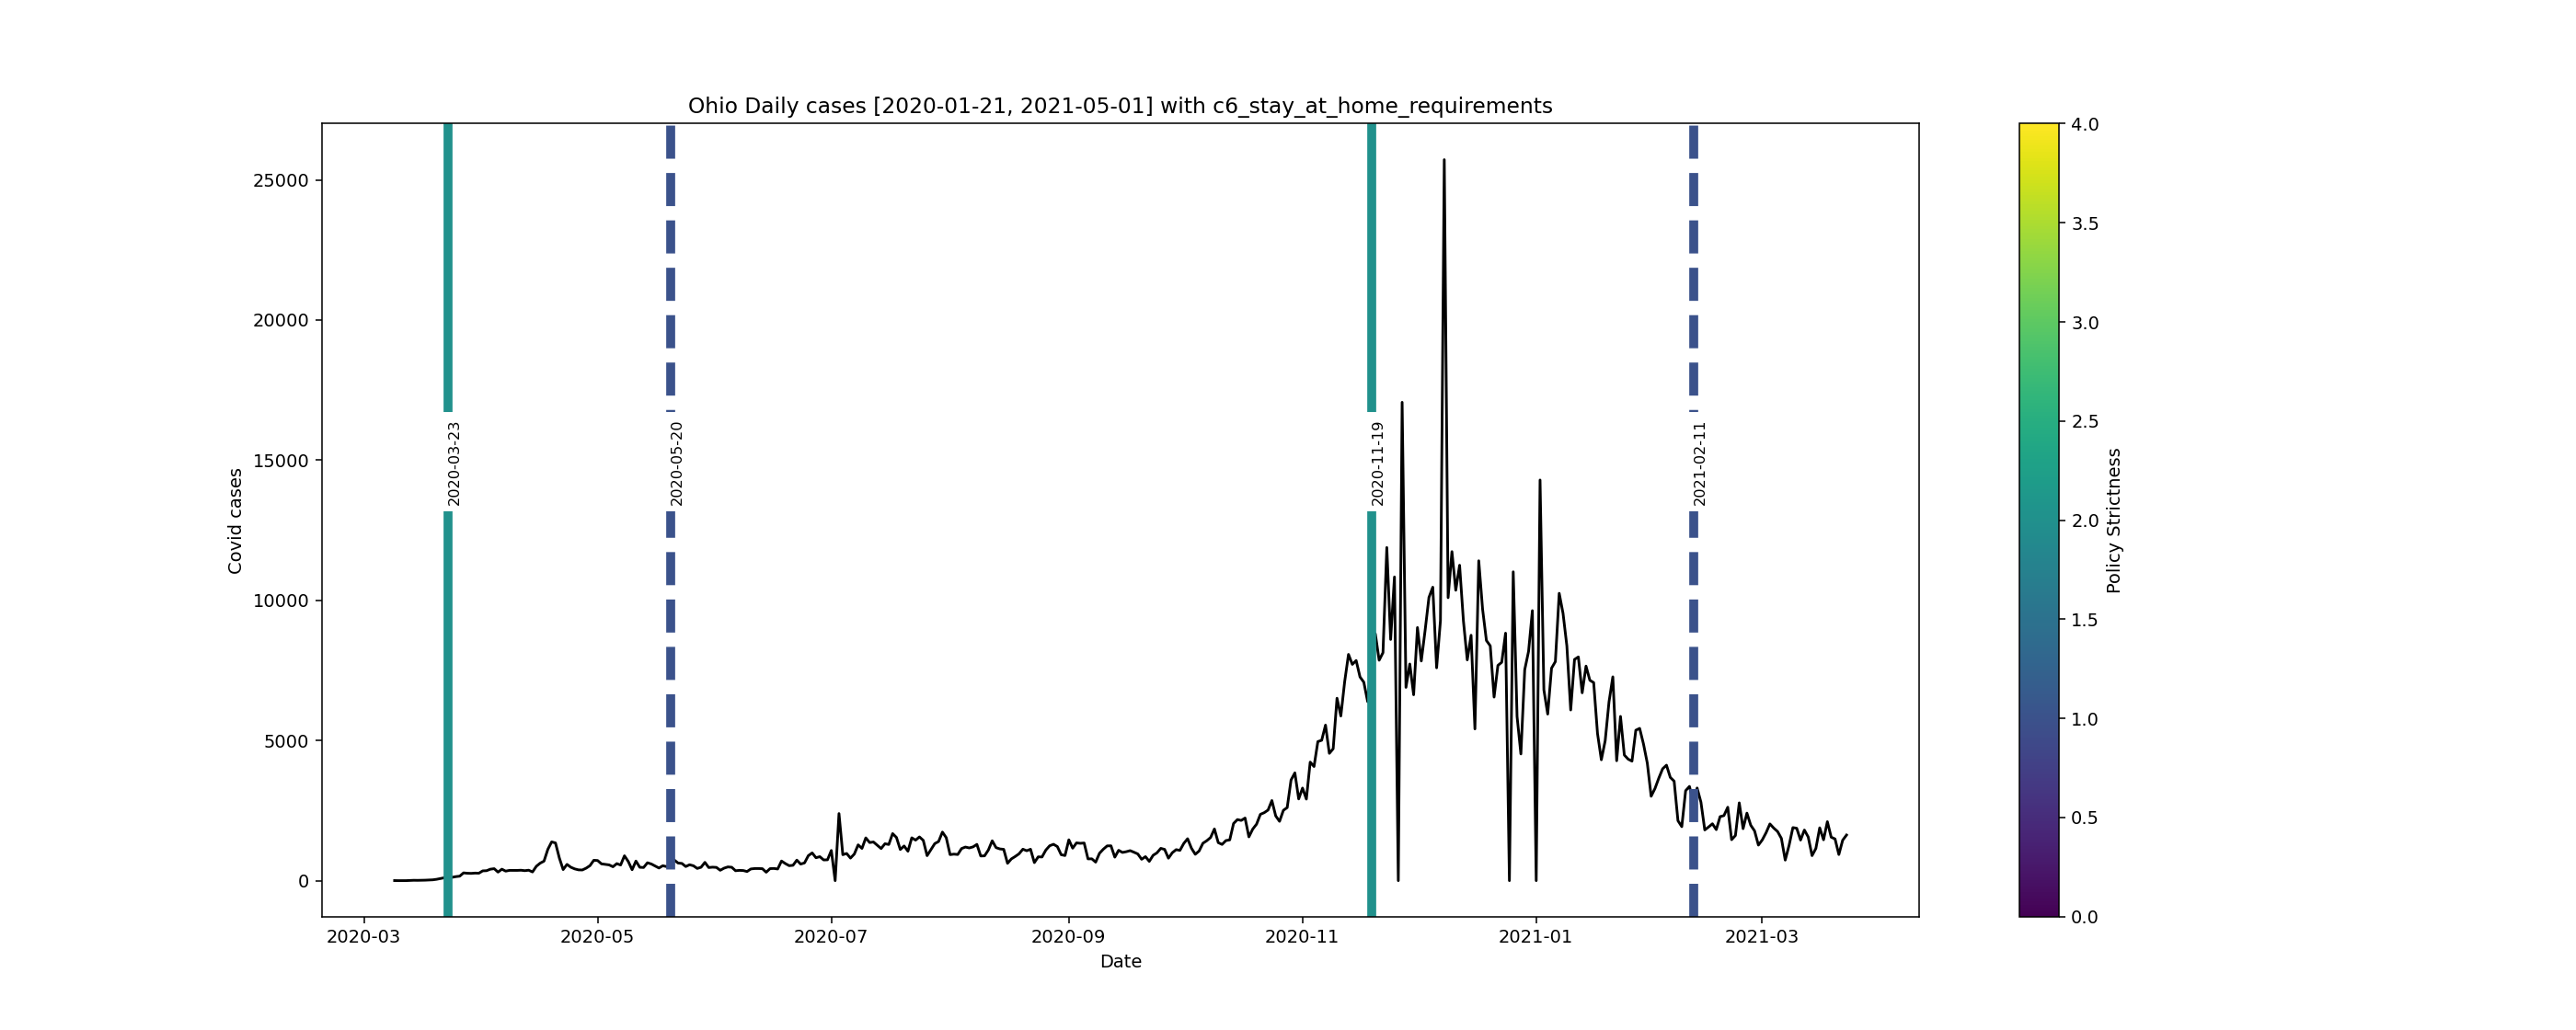

In [13]:
plot_state_policy_window(policy_df, us_state_daily_df, '2020-01-21', '2021-05-01', 'Ohio', 'c6_stay_at_home_requirements', 'cases')

<IPython.core.display.Javascript object>


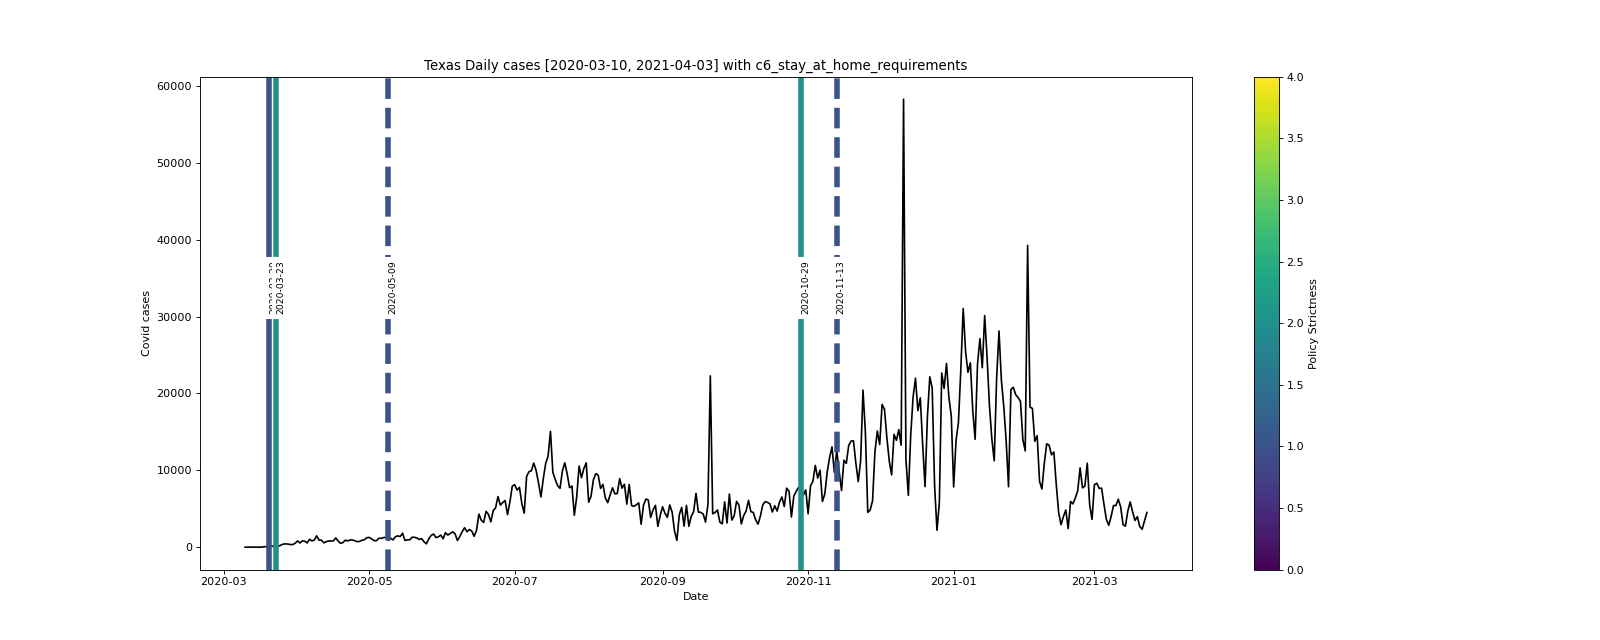

In [73]:
plot_state_policy_window(policy_df, us_state_daily_df, '2020-03-10', '2021-04-03', 'Texas', 'c6_stay_at_home_requirements', 'cases')

# Example of Downloading Delphi data

In [499]:
import covidcast
from datetime import date

In [504]:
at_away_6_data = covidcast.signal(data_source="safegraph", signal="full_time_work_prop_7dav", geo_type="state")

In [508]:
at_away_6_data.to_csv(r'at_away_6_data.csv')

In [510]:
covid_like_symp_data = covidcast.signal(data_source="fb-survey", signal="smoothed_cli", geo_type="state")

In [514]:
covid_like_symp_data.to_csv(r'cli_facebook_data.csv')

# Get population data

In [12]:
# Loads state population data
state_population_df = pd.read_csv('our_data/demographic_data/us/population_and_demographic_estimates.csv')
state_population_df

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,...,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019
0,40,3,6,1,Alabama,0,0,1,0,37991,...,37818,38678,37824,36812,37575,37698,37629,37526,36370,35594
1,40,3,6,1,Alabama,0,0,1,1,38150,...,38036,37719,38597,37854,36968,37882,37732,37904,37641,36679
2,40,3,6,1,Alabama,0,0,1,2,39738,...,39570,38202,37653,38528,37769,37123,38048,37975,38172,37904
3,40,3,6,1,Alabama,0,0,1,3,39827,...,39805,39690,38113,37716,38605,37896,37266,38170,38197,38510
4,40,3,6,1,Alabama,0,0,1,4,39353,...,39493,39872,39628,38122,37751,38625,37954,37322,38312,38476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236839,40,4,8,56,Wyoming,2,2,6,81,0,...,0,1,1,1,2,1,2,1,1,0
236840,40,4,8,56,Wyoming,2,2,6,82,0,...,0,0,1,1,1,2,1,2,1,1
236841,40,4,8,56,Wyoming,2,2,6,83,4,...,3,1,1,2,2,2,3,2,3,2
236842,40,4,8,56,Wyoming,2,2,6,84,0,...,1,2,1,0,1,1,1,2,1,2


In [13]:
# Clean column names
clean_df_cols(state_population_df)
state_population_df.rename(columns={"state":"state_num", "name":"state"}, inplace=True)

In [14]:
# Only extract sex = 0 and origin = 0 rows because these correspond to counts across sex and origin
temp_state_pop_df = state_population_df.loc[(state_population_df['sex'] == 0) & (state_population_df['origin'] == 0)]
# Group by state and sum population
state_total_pop_df = temp_state_pop_df.loc[:, ['state', 'popestimate2019']].groupby('state').sum('popestimate2019').copy()
state_total_pop_df = state_total_pop_df.reset_index()

In [15]:
# Generate cases_per_10000 column by (cases/pop) * 10000
us_state_daily_pop_df = us_state_daily.merge(state_total_pop_df, how = 'left', on='state')
us_state_daily_pop_df['cases_per_10000'] = (us_state_daily_pop_df.loc[:, 'cases'] / us_state_daily_pop_df.loc[:, 'popestimate2019']) * 10000
us_state_daily_pop_df

,state,date,cases,deaths,popestimate2019,cases_per_10000
0,Alabama,2020-03-13,6.0,0.0,4903185.0,0.012237
1,Alabama,2020-03-14,6.0,0.0,4903185.0,0.012237
2,Alabama,2020-03-15,11.0,0.0,4903185.0,0.022434
3,Alabama,2020-03-16,6.0,0.0,4903185.0,0.012237
4,Alabama,2020-03-17,10.0,0.0,4903185.0,0.020395
...,...,...,...,...,...,...
21031,Wyoming,2021-03-19,102.0,0.0,578759.0,1.762392
21032,Wyoming,2021-03-20,0.0,0.0,578759.0,0.000000
21033,Wyoming,2021-03-21,0.0,0.0,578759.0,0.000000
21034,Wyoming,2021-03-22,150.0,0.0,578759.0,2.591752


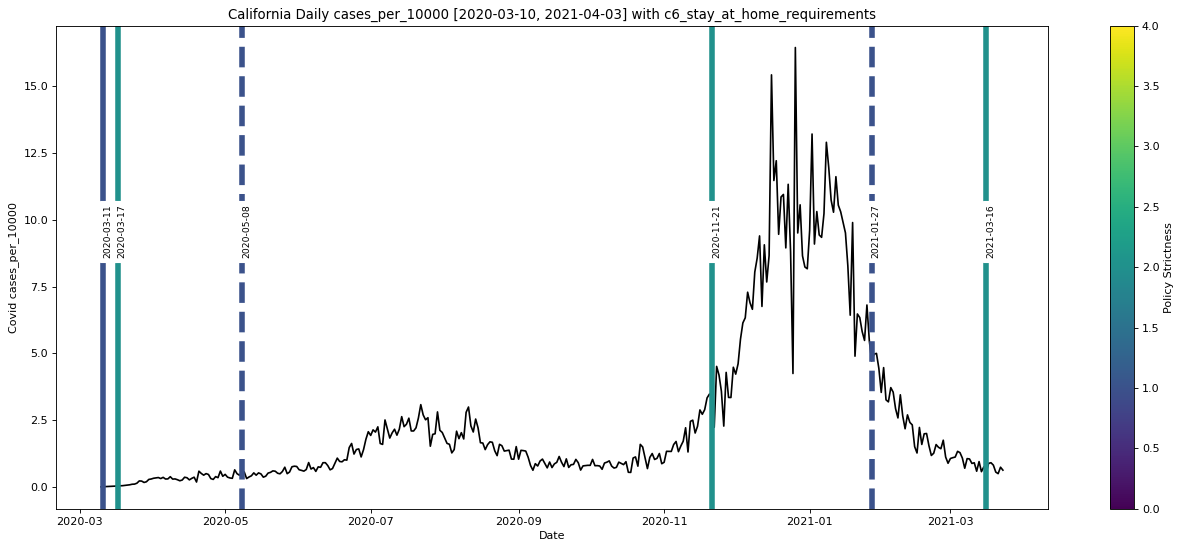

In [17]:
plot_state_policy_window(filled_policy_data_df, us_state_daily_pop_df, '2020-03-10', '2021-04-03', 'California', 'c6_stay_at_home_requirements', 'cases_per_10000')

# Generate 7 day average daily cases

In [18]:
us_state_daily_avg = us_state_daily.copy()
us_state_daily_avg['7_day_avg'] = us_state_daily_avg['cases'].rolling(window=7).mean()

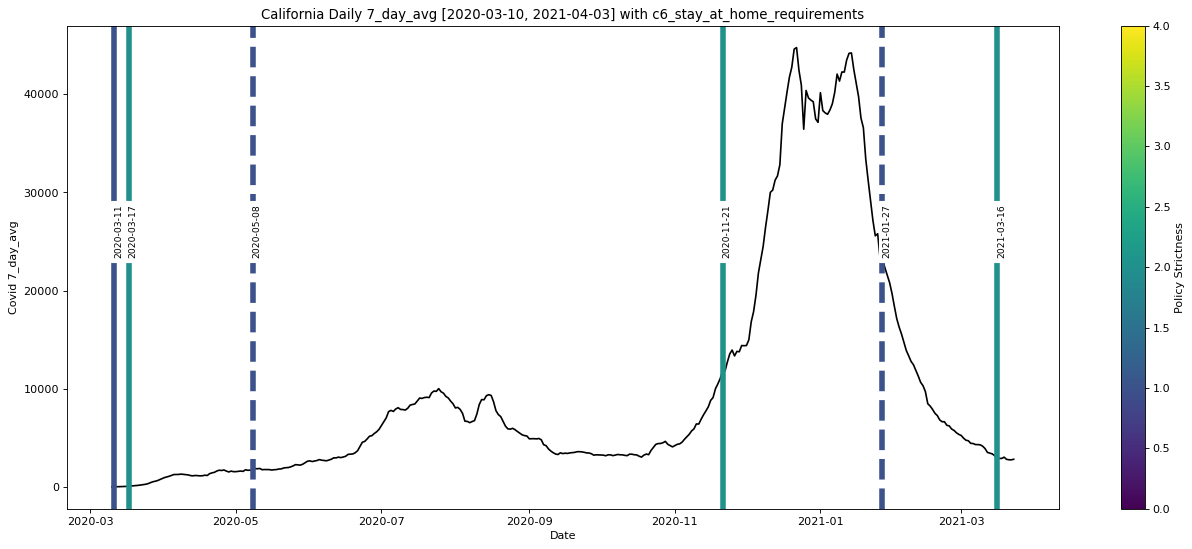

In [19]:
plot_state_policy_window(filled_policy_data_df, us_state_daily_avg, '2020-03-10', '2021-04-03', 'California', 'c6_stay_at_home_requirements', '7_day_avg')

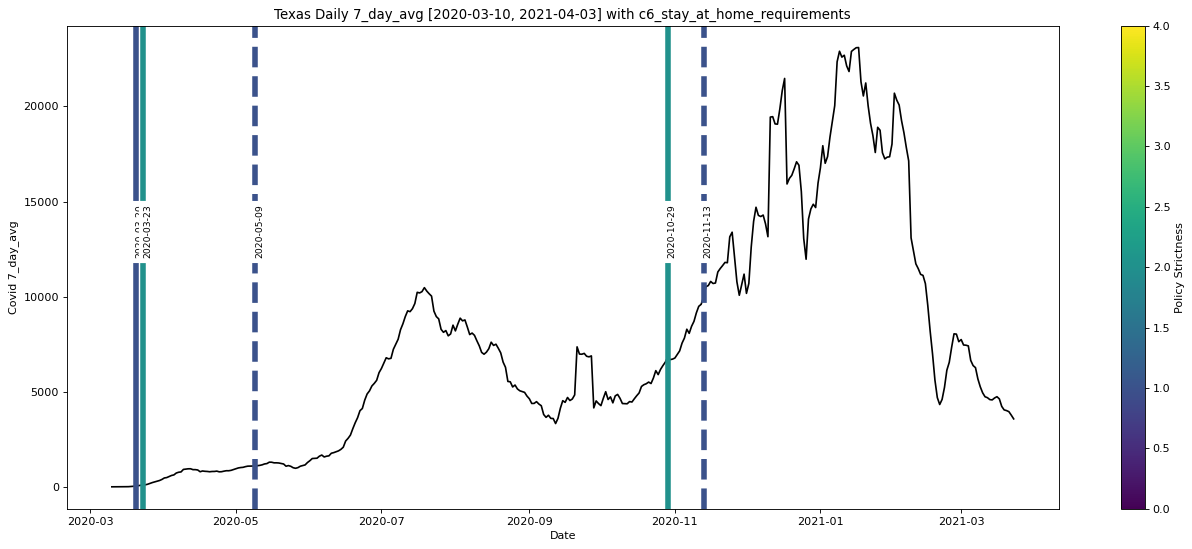

In [22]:
plot_state_policy_window(filled_policy_data_df, us_state_daily_avg, '2020-03-10', '2021-04-03', 'Texas', 'c6_stay_at_home_requirements', '7_day_avg')

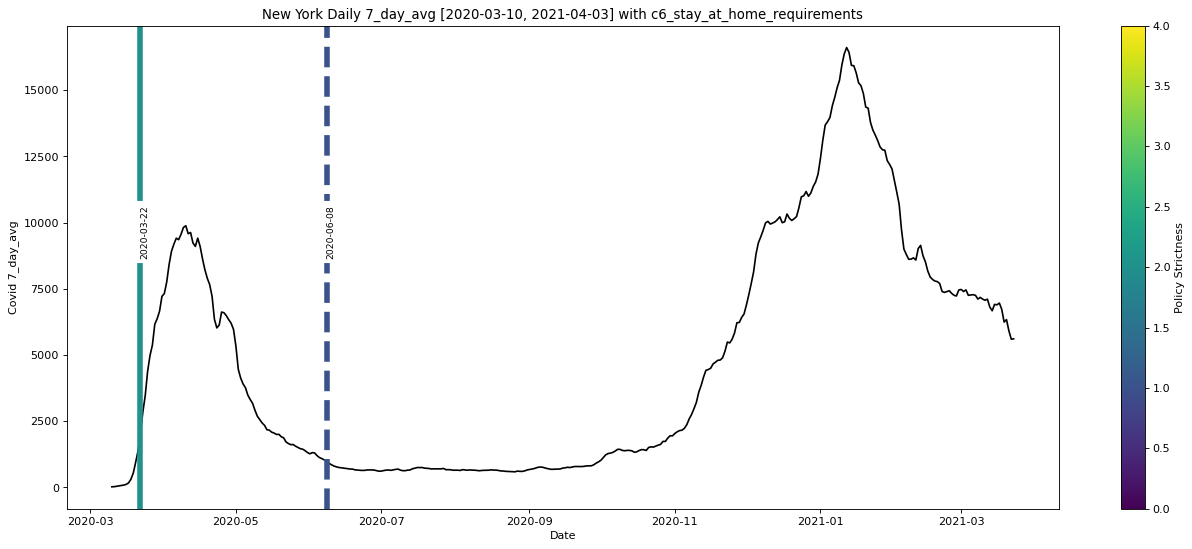

In [33]:
plot_state_policy_window(filled_policy_data_df, us_state_daily_avg, '2020-03-10', '2021-04-03', 'New York', 'c6_stay_at_home_requirements', '7_day_avg')

In [20]:
us_state_current_cases = us_state_daily.copy()
us_state_current_cases['current_infected'] = us_state_current_cases['cases'].rolling(window=15).sum()
display(us_state_current_cases.loc[10:20, :])

,state,date,cases,deaths,current_infected
10,Alabama,2020-03-23,39.0,0.0,NaN
11,Alabama,2020-03-24,46.0,0.0,NaN
12,Alabama,2020-03-25,144.0,1.0,NaN
13,Alabama,2020-03-26,152.0,2.0,NaN
14,Alabama,2020-03-27,101.0,1.0,639.0
15,Alabama,2020-03-28,81.0,0.0,714.0
16,Alabama,2020-03-29,111.0,1.0,819.0
17,Alabama,2020-03-30,120.0,6.0,928.0
18,Alabama,2020-03-31,57.0,3.0,979.0
19,Alabama,2020-04-01,109.0,14.0,1078.0


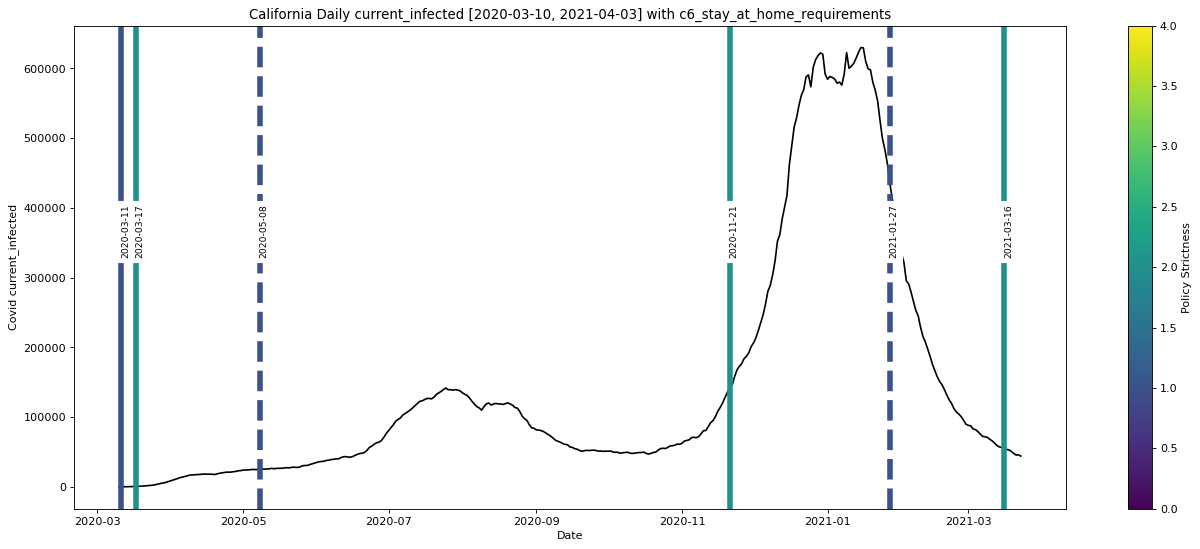

In [21]:
plot_state_policy_window(filled_policy_data_df, us_state_current_cases, '2020-03-10', '2021-04-03', 'California', 'c6_stay_at_home_requirements', 'current_infected')

# Investigating Policy Changes

In [45]:
from scripts.data_funcs import *

In [46]:
policy_df = get_state_policy_data(fill = True)[['region_name', 'date'] + policies].copy()

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [47]:
# Sift out policies with monetary values in their columns
valid_policies = policies.copy()
valid_policies.remove('h5_investment_in_vaccines')
valid_policies.remove('h4_emergency_investment_in_healthcare')
valid_policies.remove('e3_fiscal_measures')
valid_policies

['c1_school_closing',
 'c2_workplace_closing',
 'c3_cancel_public_events',
 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',
 'c6_stay_at_home_requirements',
 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls',
 'e1_income_support',
 'e2_debt/contract_relief',
 'h1_public_information_campaigns',
 'h2_testing_policy',
 'h3_contact_tracing',
 'h6_facial_coverings',
 'h7_vaccination_policy',
 'h8_protection_of_elderly_people']

In [48]:
# Count number of times a policy change was made for each policy
count_changes = []
count_stricter_changes = []
count_weaker_changes = []
# Iterates over all valid policies to count
for policy in valid_policies:
    all_sum = 0
    strict_sum = 0
    weak_sum = 0
    # Counts within state groups and sums for totals.
    # Method of counting uses diff to check for changes, assumes
    # first day for each policy in each state is 0
    for name_df, df in policy_df.groupby('region_name'):
        strict_sum += sum(df[policy].diff().iloc[1:] > 0)
        weak_sum += sum(df[policy].diff().iloc[1:] < 0)
        all_sum += sum(df[policy].diff().iloc[1:] != 0)
        
    count_changes.append(all_sum)
    count_stricter_changes.append(strict_sum)
    count_weaker_changes.append(weak_sum)
        

In [58]:
def plot_bar_graph(counts, categories, count_labels, main_title, y_title):
    x = np.arange(len(categories))  # the category locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    for i in range(len(counts)):
        pos = x - width/2 + i * width/len(counts)
        rects = ax.bar(pos, counts[i], width, label=count_labels[i])
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_title)
    ax.set_xticks(x)
    ax.set_xticklabels([c[0:2] for c in categories])
    
    ax.legend()
    ax.set_title(main_title)

<IPython.core.display.Javascript object>


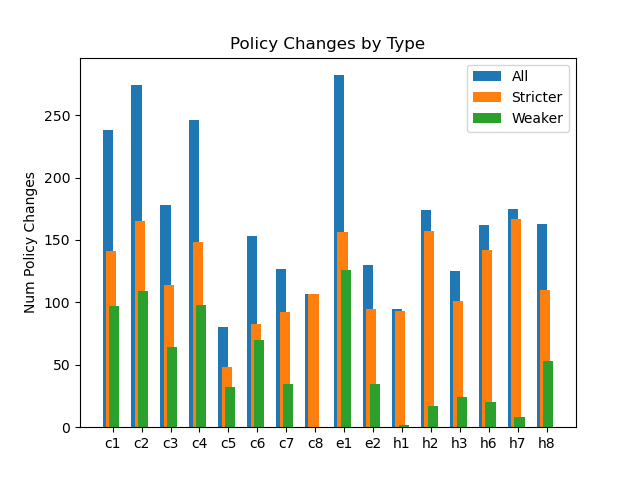

In [59]:
plot_bar_graph([count_changes, count_stricter_changes, count_weaker_changes], valid_policies, ['All', 'Stricter', 'Weaker'], 'Policy Changes by Type', 'Num Policy Changes')

In [51]:
# Creates a policy_diff_df where a boolean entry of True for a policy column
# means that a policy change for that policy was implemented on that day
policy_diff_df = policy_df.copy()
for policy in valid_policies:
    running_df = None
    for name_df, df in policy_df.groupby('region_name'):
        diff_df = df.copy()
        diff_df[policy + '_diff'] = diff_df[policy].diff().fillna(0) != 0
        if running_df is None:
            running_df = diff_df[['region_name', 'date', policy + '_diff']].copy()
        else:
            running_df = pd.concat([running_df, diff_df[['region_name', 'date', policy + '_diff']]], axis = 0)
            
    policy_diff_df = policy_diff_df.merge(running_df, on=['region_name', 'date'], how='left')
policy_diff_df = policy_diff_df.drop(policies, axis = 1)

In [52]:
# Creates a window_policy_diff_df where each entry denotes the number of policy
# changes that happen for that policy within the window of 
# 14 days around an entry's corresponding date
running_df = None
col_names = [p + '_diff' for p in valid_policies]
for name_df, df in policy_diff_df.groupby('region_name'):
    curr_policy_diffs = df[col_names].copy()
    combined_policy_diff_df = (
        curr_policy_diffs.rolling(8, min_periods=1).sum() +
        curr_policy_diffs.iloc[::-1].rolling(8, min_periods=1).sum().iloc[::-1] - 
        curr_policy_diffs)
    combined_policy_diff_df = pd.concat([df['region_name'], combined_policy_diff_df], axis = 1)
    if running_df is None:
        running_df = combined_policy_diff_df
    else:
        running_df = pd.concat([running_df, combined_policy_diff_df], axis = 0)
window_policy_diff_df = running_df.copy()

In [53]:
# Counts the number of times a policy is changed on its own.
# That is, we count the number of times a policy is changed without
# any other policy being changed in a 14 day window around a particular date
count_alone = {}
for p in col_names:
    count_alone[p] = 0
    
for name_df, df in policy_diff_df.groupby('region_name'):
    curr_diffs = df[col_names].copy()
    for index, row in curr_diffs.iterrows():
        if sum(row) == 1:
            if sum(window_policy_diff_df.iloc[index] != 0) == 1:
                count_alone[row.idxmax(axis = 1)] += 1
                

<IPython.core.display.Javascript object>


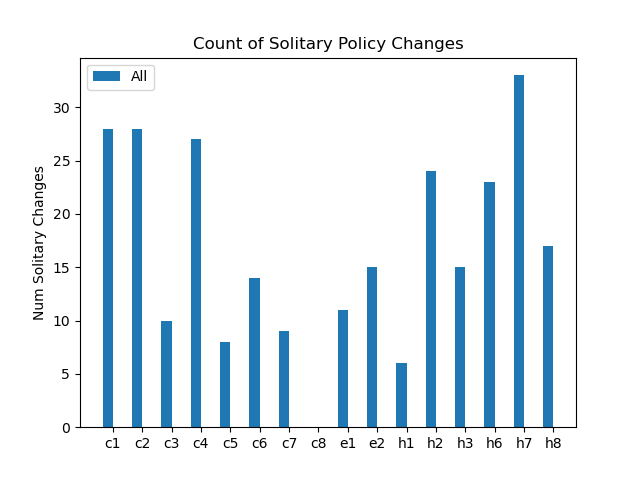

In [60]:
plot_bar_graph([list(count_alone.values())], valid_policies, ['All'], 'Count of Solitary Policy Changes','Num Solitary Changes')

<IPython.core.display.Javascript object>


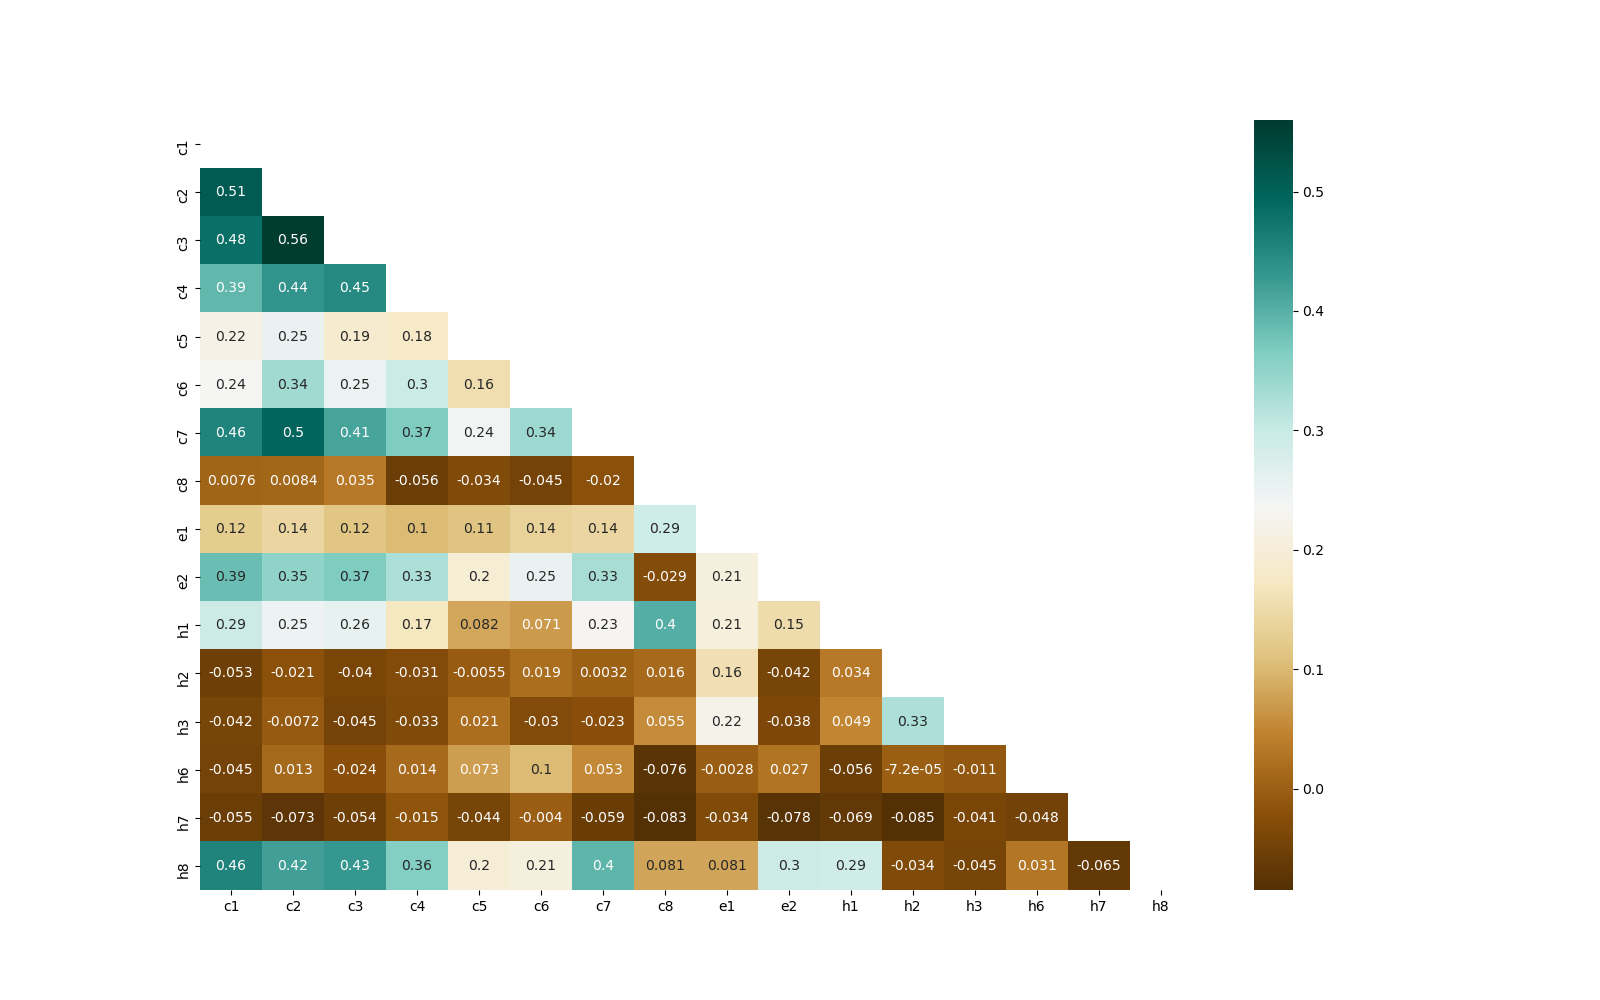

<AxesSubplot:>

In [61]:
plt.figure(figsize=(16, 10))
window_policy_diff_df.columns = [l[0:2] for l in window_policy_diff_df.columns]
policies_corr_mat = window_policy_diff_df.corr()
sns.heatmap(policies_corr_mat, annot=True, cmap='BrBG', 
           mask=np.triu(np.ones_like(policies_corr_mat)))

<IPython.core.display.Javascript object>


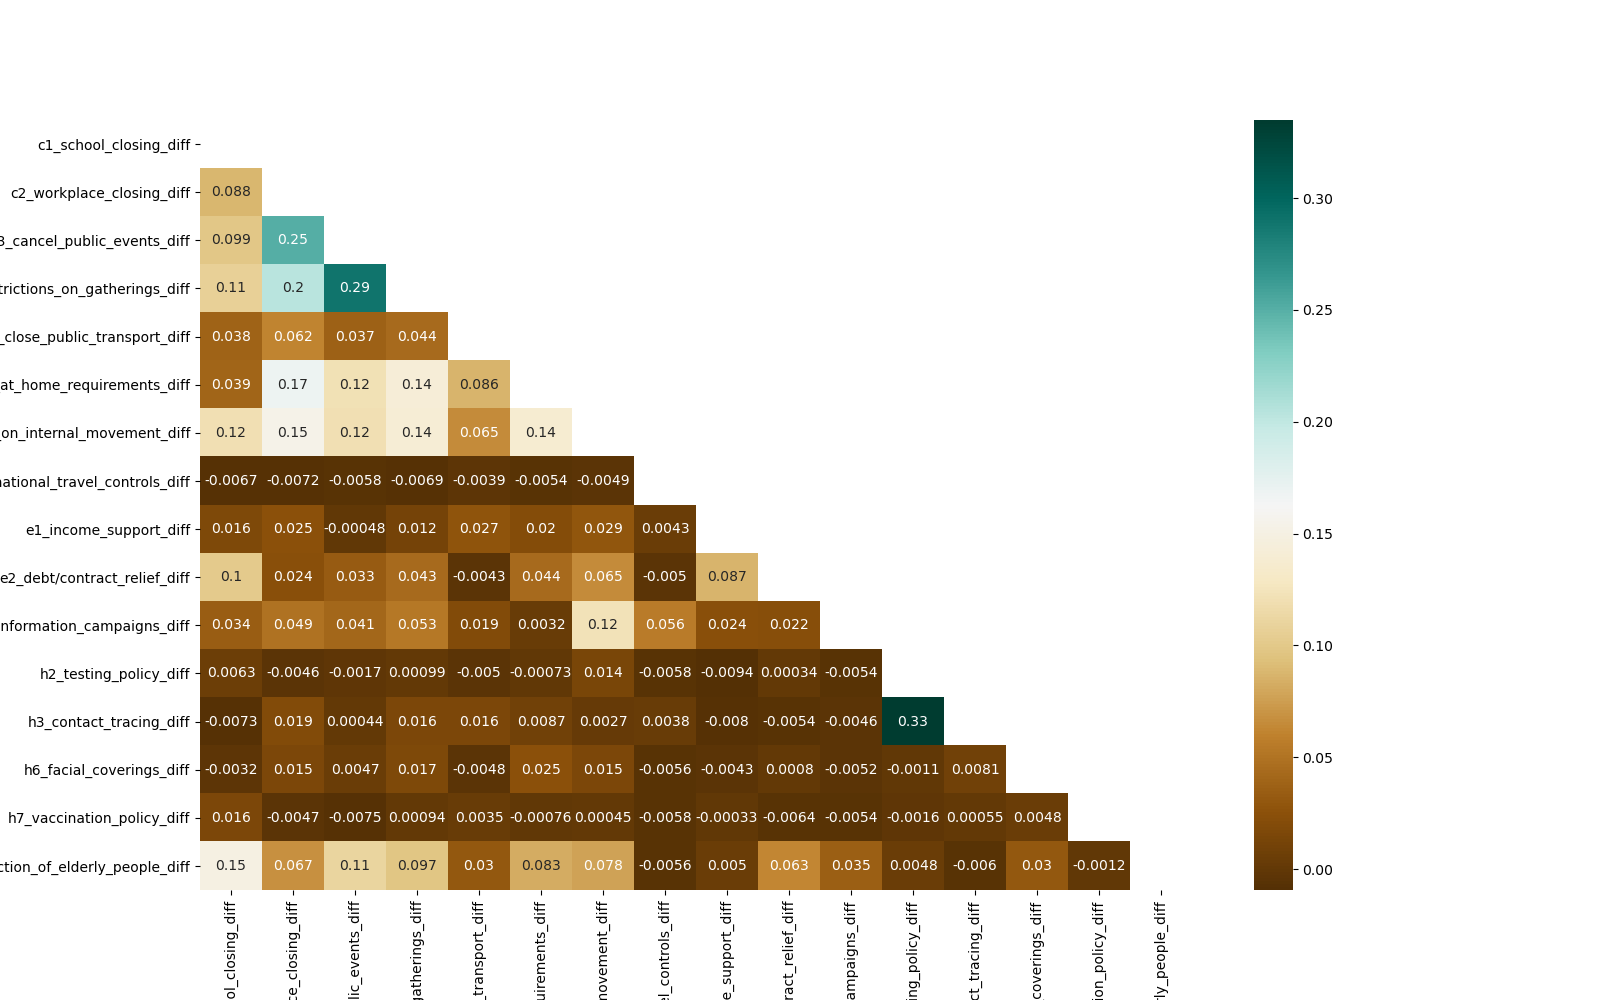

<AxesSubplot:>

In [44]:
plt.figure(figsize=(16, 10))
policies_corr_mat = policy_diff_df.corr()
sns.heatmap(policies_corr_mat, annot=True, cmap='BrBG', 
           mask=np.triu(np.ones_like(policies_corr_mat)))